Data downloaded from https://data.mendeley.com/datasets/5cxyb5fp4f/1 
Author says the data encompasses the primary activities over a span of November 2015 to December 2018 concerning a non-life motor insurance portfolio. 

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
df = pd.read_csv('/Users/mwilson/Documents/GitHub/insurance/data/Motor vehicle insurance data.csv', sep=';')

In [133]:
# check basic information about dataset, set missing data to -1

print("Rows, columns: ", df.shape)
print("Missing entries by column")
print(df.isna().sum())
dff = df.select_dtypes(include=np.number)
df = df.fillna(-1)

Rows, columns:  (105555, 30)
Missing entries by column
ID                          0
Date_start_contract         0
Date_last_renewal           0
Date_next_renewal           0
Date_birth                  0
Date_driving_licence        0
Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Lapse                       0
Date_lapse              70408
Payment                     0
Premium                     0
Cost_claims_year            0
N_claims_year               0
N_claims_history            0
R_Claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Year_matriculation          0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                1764
Length                  10329
Weight                      0
dtype: int64


Rows, columns in dataframe  (19646, 30)
Max claim:  260853.24 Median claim:  289.435 Mean claim:  825.0402814822355


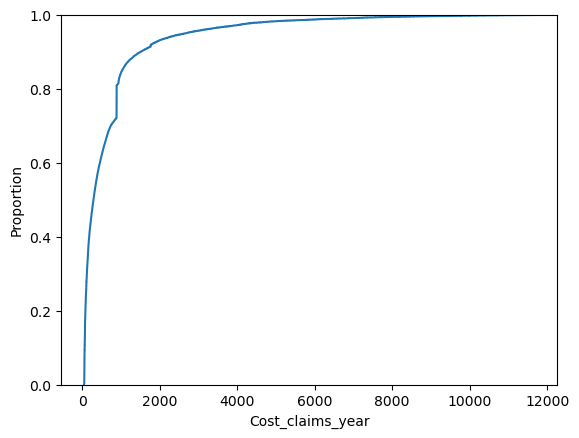

In [134]:
# expect many with cost claims  = 0, and we are right
# distribution very skewed, so cut off top 0.1% to make graph more readable

dfp = df[df['Cost_claims_year'] >0]
print("Rows, columns in dataframe ", dfp.shape)
print("Max claim: ", dfp['Cost_claims_year'].max(), "Median claim: ", dfp['Cost_claims_year'].median(),
      "Mean claim: ", dfp['Cost_claims_year'].mean())
q = df['Cost_claims_year'].quantile(0.999)
dfp = dfp[dfp['Cost_claims_year'] < q]
p = sns.ecdfplot(data=dfp, x='Cost_claims_year') # note the kink near 1000
#ax.set_title("Empirical CDF of Cost/claim_year")
plt.show()

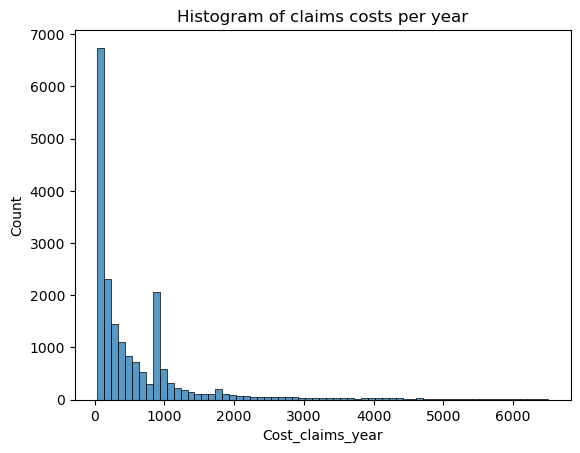

In [135]:
# look at histogram of cost per claim for the year

dfp2 = dfp[dfp['Cost_claims_year'] < dfp['Cost_claims_year'].quantile(0.99)]
g = sns.histplot(data=dfp2, x='Cost_claims_year', binwidth=100) 
a = g.set_title("Histogram of claims costs per year")
# seems many claim costs are just under 1000, perhaps a payout limit enforced

In [136]:
# brief look at high value claims

df['Cost_claims_year'].nlargest(100)

55159    260853.24
63282    236285.18
95817    128809.73
92967     71968.87
44051     59656.65
           ...    
76347     12869.29
58944     12806.00
69246     12592.80
57882     12552.26
30798     12406.86
Name: Cost_claims_year, Length: 100, dtype: float64

In [137]:
# The vehicle types (1=motorbike, 2=van, 3=car, 4=agricultural vehicle) differ in claim frequency and cost/claim

def f(row):
    return row['Cost_claims_year']/max(1,row['N_claims_year'])
df['Cost/claim_year'] = df.apply(f, axis=1)
cols = ['Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Cost/claim_year','Type_risk']
temp = df.loc[:, cols]
temp = temp.groupby('Type_risk')
temp.aggregate('mean')

,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Cost/claim_year
Type_risk,,,,,
1,36.351004,0.145378,1.603270,0.173970,25.648506
2,166.345241,0.567590,3.507796,0.513436,89.510952
3,165.101086,0.396747,2.768743,0.441156,93.694393
4,0.226404,0.001175,0.831962,0.008484,0.226404


In [138]:
# The vehicle types (1=motorbike, 2=van, 3=car, 4=agricultural vehicle) differ in yearly claim cost versus premium,
# but cars and vans not so much

def f(row):
    return row['Cost_claims_year']/row['Premium']
df['Cost/prem'] = df.apply(f, axis=1)
cols = ['Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Cost/prem','Type_risk']
temp = df.loc[:, cols]
temp = temp.groupby('Type_risk')
temp.aggregate('mean')

,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Cost/prem
Type_risk,,,,,
1,36.351004,0.145378,1.603270,0.173970,0.259122
2,166.345241,0.567590,3.507796,0.513436,0.529444
3,165.101086,0.396747,2.768743,0.441156,0.494793
4,0.226404,0.001175,0.831962,0.008484,0.001650


In [139]:
# frequency of vehicle types in dataset

df['Type_risk'].value_counts()

Type_risk
3    82990
2    13212
1     8502
4      851
Name: count, dtype: int64

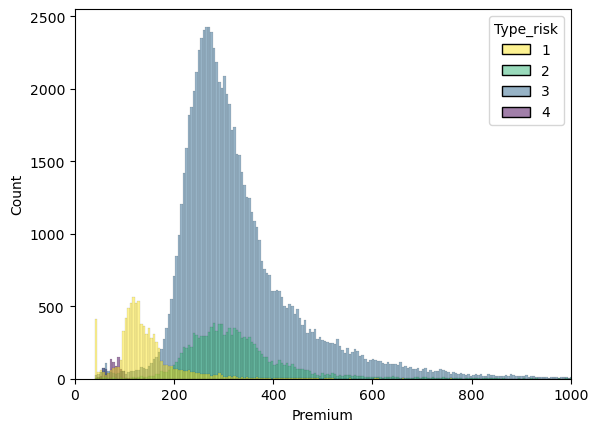

In [140]:
# premium distribution by vehicle type

sns.histplot(data=df, x="Premium", hue="Type_risk", palette='viridis_r')
plt.xlim(0, 1000)
plt.show()

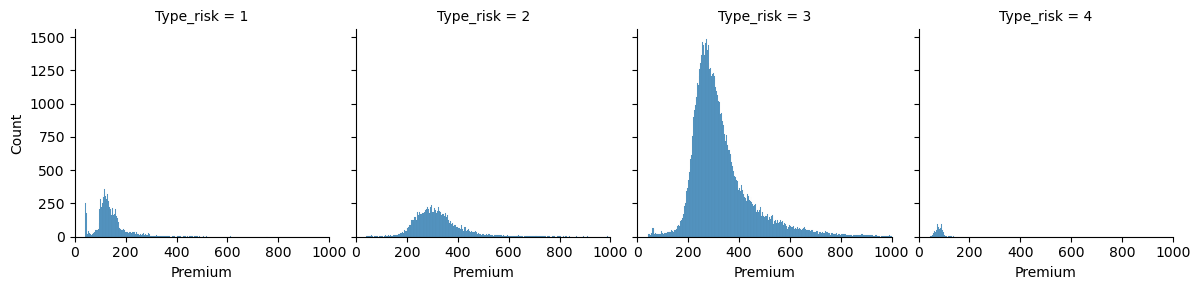

In [141]:
# same thing, separate plots

sns.displot(
        df,
        x="Premium",
        col="Type_risk",
        kind="hist",
        binwidth=3,
        height=3,
        facet_kws=dict(margin_titles=True),
    )
plt.xlim(0, 1000)
plt.show()

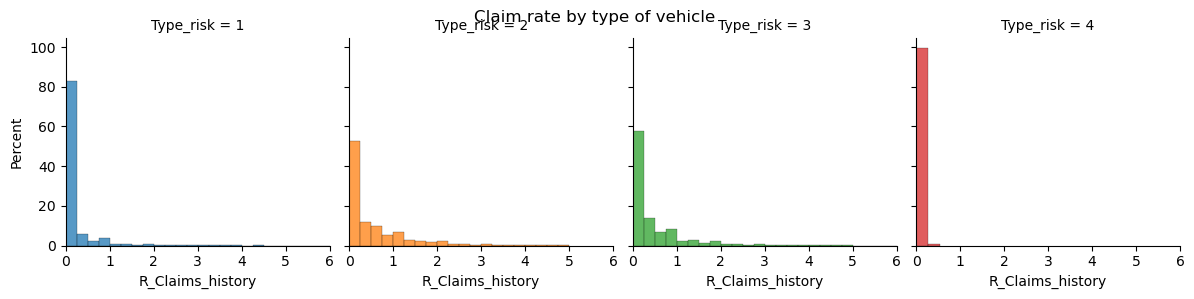

In [142]:
# now look at claim frequency

g = sns.FacetGrid(df, col="Type_risk", hue="Type_risk")
g.map(sns.histplot, "R_Claims_history", binwidth = 0.25, stat = 'percent')
g.set(xlim=(0, 6))
g.fig.suptitle("Claim rate by type of vehicle")
plt.show()

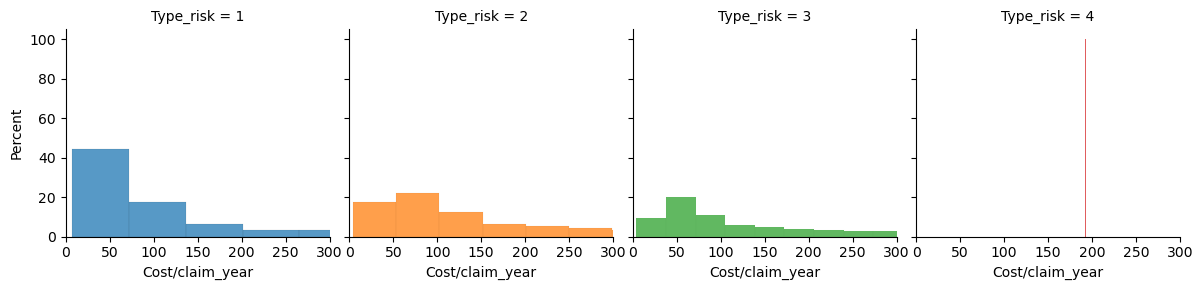

In [143]:
# cost/claim_year distribution by vehicle type, zero claims omitted since too frequent

dfp = df[df['Cost/claim_year']>0]
g = sns.FacetGrid(dfp, col="Type_risk", hue="Type_risk")
g.map(sns.histplot, "Cost/claim_year",  stat = 'percent')
g.set(xlim=(0, 300))
plt.show()

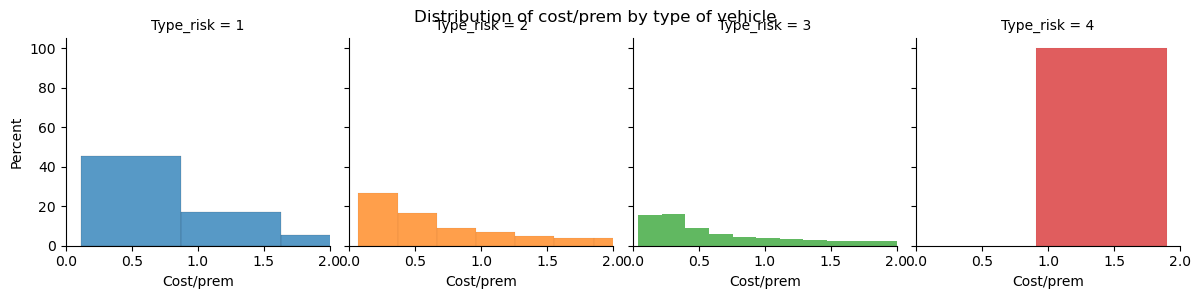

In [154]:
# cost/premium distribution by vehicle type, zero claims omitted since too frequent

dfp = df[df['Cost/prem']>0]
g = sns.FacetGrid(dfp, col="Type_risk", hue="Type_risk")
g.map(sns.histplot, "Cost/prem",stat = 'percent').fig.suptitle("Distribution of cost/prem by type of vehicle")
g.set(xlim=(0, 2))
plt.show()



In [145]:
# total costs in year vs total premium - aggregated over years

print ('Total costs: ', df['Cost_claims_year'].sum(), 'Total premium: ', df['Premium'].sum() )

# worth checking to see whether bad customers

df['Cost/prem'].nlargest(100)


Total costs:  16208741.370000001 Total premium:  33344038.88


63282    1071.248039
55159     418.194883
95817     358.402142
6073      188.982252
51361     177.481005
            ...     
42408      39.470691
86962      39.398935
42585      39.141671
49161      38.933954
76347      38.715111
Name: Cost/prem, Length: 100, dtype: float64

In [146]:
# seems to be a difference between policies coming from agents versus brokers

cols = ['Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Distribution_channel','Cost/claim_year','Cost/prem']
temp = df.loc[:, cols]
temp = temp.groupby('Distribution_channel')
temp.aggregate('mean')

,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Cost/claim_year,Cost/prem
Distribution_channel,,,,,,
0,134.762863,0.365937,3.169121,0.384119,77.288360,0.433762
1,176.407083,0.429657,2.244343,0.475133,98.666248,0.527733


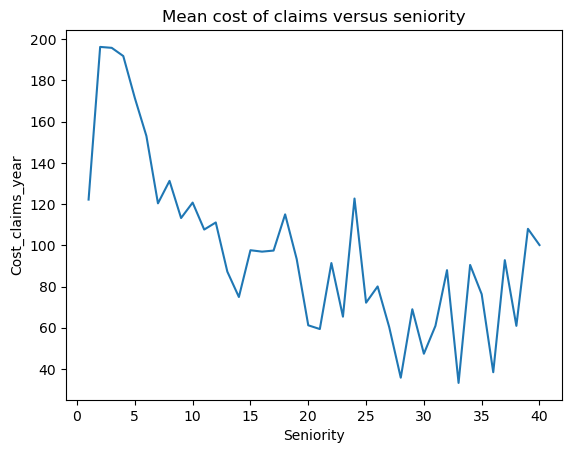

In [152]:
# claim costs by seniority (length of time having a policy with company)

cols = ['Seniority',  'Cost_claims_year','N_claims_year','N_claims_history','R_Claims_history','Distribution_channel','Cost/claim_year','Cost/prem']
temp = df.loc[:, cols]
temp = temp.groupby('Seniority')
t = temp.aggregate('mean')
sns.lineplot(t, x='Seniority',y='Cost_claims_year').set_title("Mean cost of claims versus seniority")
plt.show()